In [ ]:
# !pip install matplotlib tqdm numpy

In [ ]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [ ]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [ ]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    # subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    # print(subfolders)
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        print(f"Evaluating algorithm: {config['alg'].name}")
        
        times = []
        
        for i in range(10):
            print(f"Evaluating test {i + 1} of {10}")
            schedule_stats = review_task_sets_in_parallel_multi(
                algorithm=config["alg"],
                folder_name=folder_name,
                num_processors=config["processors"],
                #num_clusters=config["clusters"],
                heuristic=config["heuristic"],
                number_of_workers=worker_quantity)
                # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
                # execution_times[num_tasks] = success_rate
            end_time = time() - start_time
            times.append(end_time)
        average_time = np.mean(times)
        print(average_time)

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": average_time
            }
        )

    return execution_times

In [ ]:
def plot_average_execution_time(data):
    for result in data:
        print(f"Time taken for {result['workers']} workers: {result['time']}")

    workers = [result["workers"] for result in data]
    times = [result["time"] for result in data]

    plt.figure(figsize=(12, 6))
    plt.bar(workers, times, color='teal', width=0.6)
    plt.xlabel('Number of Workers')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Time Taken vs Number of Workers')
    plt.xticks(workers)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

In [47]:
config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "processors": 8,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")

Total files considered: 1000
Evaluating test 6 of 10
Total files considered: 1000
Evaluating test 7 of 10
Total files considered: 1000
Evaluating test 8 of 10
Total files considered: 1000
Evaluating test 9 of 10
Total files considered: 1000
Evaluating test 10 of 10
Total files considered: 1000
3.686014199256897
Executing with: 4 workers.
Evaluating algorithm: PARTITIONED_EDF
Evaluating test 1 of 10
Total files considered: 1000
Evaluating test 2 of 10
Total files considered: 1000
Evaluating test 3 of 10
Total files considered: 1000
Evaluating test 4 of 10
Total files considered: 1000
Evaluating test 5 of 10
Total files considered: 1000
Evaluating test 6 of 10
Total files considered: 1000
Evaluating test 7 of 10
Total files considered: 1000
Evaluating test 8 of 10
Total files considered: 1000
Evaluating test 9 of 10
Total files considered: 1000
Evaluating test 10 of 10
Total files considered: 1000
3.419055771827698
Executing with: 5 workers.
Evaluating algorithm: PARTITIONED_EDF
Evaluati

Time taken for 1 workers: 6.596227693557739
Time taken for 2 workers: 3.8186988830566406
Time taken for 3 workers: 3.686014199256897
Time taken for 4 workers: 3.419055771827698
Time taken for 5 workers: 3.0861873626708984
Time taken for 6 workers: 3.0592885971069337
Time taken for 7 workers: 3.355855345726013
Time taken for 8 workers: 2.9573366403579713
Time taken for 9 workers: 3.266788911819458
Time taken for 10 workers: 3.320210075378418
Time taken for 11 workers: 3.178168034553528
Time taken for 12 workers: 4.535564613342285
Time taken for 13 workers: 5.818947768211364
Time taken for 14 workers: 6.153588056564331
Time taken for 15 workers: 5.7455929040908815
Time taken for 16 workers: 5.527410578727722
Time taken for 17 workers: 6.374601697921753
Time taken for 18 workers: 6.361833214759827
Time taken for 19 workers: 6.180022740364075
Time taken for 20 workers: 6.454755115509033
Time taken for 21 workers: 6.769843673706054
Time taken for 22 workers: 6.849557328224182
Time taken for

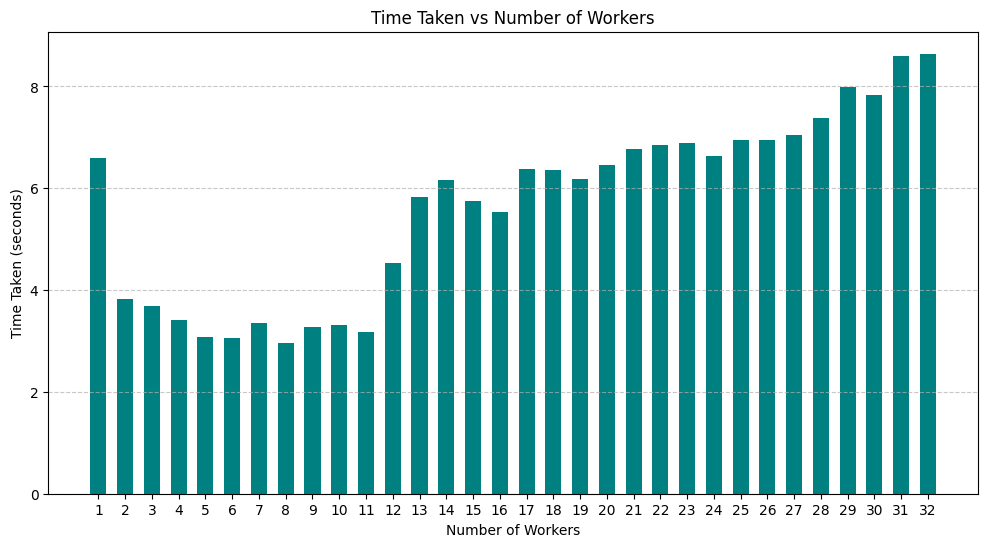

In [48]:
plot_average_execution_time(results)

In [49]:
config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.GLOBAL_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "processors": 8,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")


Executing with: 1 workers.
Evaluating algorithm: GLOBAL_EDF
Evaluating test 1 of 10


AssertionError: daemonic processes are not allowed to have children

In [ ]:
plot_average_execution_time(results)